In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

if os.getcwd() == '/content':
  % cd drive/MyDrive/exjobb_project

print(os.getcwd())
print(os.listdir('bert'))


/content/drive/MyDrive/exjobb_project
/content/drive/MyDrive/exjobb_project
['bert-base-swedish-cased', 'electra-small-swedish-cased-discriminator', 'electra-base-swedish-cased-discriminator', 'bert-base-multilingual-cased']


In [3]:
from transformers import BertModel
from transformers import BertTokenizer
from transformers import PretrainedConfig

# metrics
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import multilabel_confusion_matrix

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

import json
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import BCELoss
from collections import Counter

%matplotlib inline

In [4]:
# use an RNG seed for reproducibility
seed_list = [2, 4, 8]

SEED = seed_list[1]

# set the RNG seed
np.random.seed(SEED)
torch.manual_seed(SEED)

In [5]:
path_to_data = './data'

# create dataframe from sessions.json
df = pd.read_json(f'{path_to_data}/sessions/sessions_02.json')
df.head()

# create dictionaries for switching between symptom and id
id2sym = {}
sym2id = {}

with open(f'{path_to_data}/symptoms/symptoms_02.json') as json_file:
    data = json.load(json_file)
    for sym in data:
        id2sym[sym['id']] = sym['name']
        sym2id[sym['name']] = sym['id']
        
print(f'Numer of symptoms in id2sym: {len(sym2id)}')
        
# remove labels that have less than m occurrences
m = 0

labels_list = df['confirmed'].tolist()
labels_list = sum(labels_list, [])
c = Counter(labels_list)
for i in range(len(df)):
    to_remove = []
    
    # find labels that should be removed 
    for j in range(len(df['confirmed'][i])):
        if c[df['confirmed'][i][j]] < m:
            to_remove.append(j)
            
    # remove the labels
    shift = 0
    for j in range(len(to_remove)):
        df['confirmed'][i].pop(to_remove[j]-shift)
        shift += 1
    
        
# add column with the symptom names
sym_names = []

for syms in df['confirmed']:
    if len(syms) != 0:
        sym_names.append([id2sym[x] for x in syms])
    else:
        sym_names.append([])

df['labels'] = sym_names

# remove all rows with no confirmed labels
df = df[df['confirmed'].map(len) > 0]
df = df.reset_index(drop=True)

Numer of symptoms in id2sym: 245


In [6]:
df.drop('confirmed', inplace=True, axis=1)
df.drop('suggested', inplace=True, axis=1)
#df = df[0:100]
df.head()

,text,labels
0,Har fått besvärlig eksem på händerna,"[Hudbesvär, Synliga hudbesvär]"
1,Muskelsvaghet och trötthet känner mig skakig o...,"[Muskelsvaghet, Trötthet]"
2,Vår son har röda hudutslag i nacke och knävecken,"[Hudbesvär, Synliga hudbesvär]"
3,hosta 5 dagar,[Hosta]
4,Huvudvärk,[Huvudvärk]


In [7]:
# choose which transformer model to use
#path_to_bert = r'./bert/electra-small-swedish-cased-discriminator'
#path_to_bert = r'./bert/electra-base-swedish-cased-discriminator'
#path_to_bert = r'./bert/bert-base-swedish-cased'
#path_to_bert = r'./bert/bert-base-multilingual-cased'

# TEMPORARY lines for testing out XLNet
from transformers import XLNetModel, XLNetTokenizer
from transformers.modeling_utils import SequenceSummary
path_to_bert = r'./xlnet/xlnet-base-cased'
tok = XLNetTokenizer.from_pretrained(path_to_bert)


#tok = BertTokenizer.from_pretrained(path_to_bert)

# train a multilabel_binarizer on the labels
labels = df['labels'].tolist()
multilab_bin = MultiLabelBinarizer()
multilab_bin.fit(labels)


class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, multilab_bin, max_len):
        self.tokenizer = tokenizer
        self.multilab_bin = multilab_bin
        self.data = dataframe
        self.text = self.data['text']
        self.labels = self.data['labels']
        self.max_len = max_len
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, index):
        text = str(self.text[index])
        text = ' '.join(text.split())
        
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            #'labels': torch.tensor(np.sum(self.multilab_bin.transform([self.labels[index]]), axis=0), dtype=torch.float)
            'labels': torch.tensor(self.multilab_bin.transform([self.labels[index]]).reshape(-1,), dtype=torch.float)
        }        

In [8]:
batch_size = 16

# max number of tokens in text
#max_len = 200
max_len = 0
for i in range(len(df['text'])):
  text = df['text'][i]
  inputs = tok.encode_plus(
            text,
            None,
            add_special_tokens=True,
            padding=False,
            return_token_type_ids=True
            )
  if len(inputs['input_ids']) > max_len:
    max_len = len(inputs['input_ids'])
print(f'Max token length: {max_len}')


train_dataset, test_dataset = train_test_split(df,
                                        test_size=0.2,
                                        shuffle=True)
train_dataset = train_dataset.reset_index(drop=True)
test_dataset = test_dataset.reset_index(drop=True)

train_set = CustomDataset(train_dataset, tok, multilab_bin, max_len)
test_set = CustomDataset(test_dataset, tok, multilab_bin, max_len)

train_params = {'batch_size': batch_size,
                'shuffle': True,
                'num_workers': 0
               }
test_params = {'batch_size': batch_size,
               'shuffle': True,
               'num_workers': 0
              }

train_loader = DataLoader(train_set, **train_params)
test_loader = DataLoader(test_set, **test_params)

print(f'Train set: {len(train_dataset)} samples')
print(f'Test set: {len(test_dataset)} samples')

Max token length: 256
Train set: 5232 samples
Test set: 1308 samples


In [9]:
# decide which device to use. use cuda if available
dev = ''
if torch.cuda.is_available():
    dev = 'cuda:0'
else:
    dev = 'cpu'

print(f'dev = {dev}')
print(f'Number of available GPUs: {torch.cuda.device_count()}')

# print the device names
for i in range(torch.cuda.device_count()):
  print(f'Device {i}: {torch.cuda.get_device_name(i)}')

device = torch.device(dev)

dev = cuda:0
Number of available GPUs: 1
Device 0: Tesla T4


In [10]:
class BERTClass(nn.Module):
    def __init__(self, config, path_to_bert, output_dim):
        super(BERTClass, self).__init__()
        #config = PretrainedConfig.from_json_file(f'{path_to_bert}/config.json')
        self.bert = BertModel.from_pretrained(path_to_bert)
        #self.bert = BertModel(config)
        self.dropout = torch.nn.Dropout(config.hidden_dropout_prob)
        self.fc = nn.Linear(config.hidden_size, output_dim)
        self.sigm = nn.Sigmoid()
        
    def forward(self, ids, mask, token_type_ids):
        x = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids)
        x = self.dropout(x[1])
        x = self.fc(x)
        output = self.sigm(x)
        return output

class XLNetClass(nn.Module):
    def __init__(self, config, path_to_bert, output_dim):
        super(XLNetClass, self).__init__()
        self.transformer = XLNetModel.from_pretrained(path_to_bert)
        self.fc1 = nn.Linear(config.d_model, 1)
        self.fc2 = nn.Linear(max_len, output_dim)
        #self.sequence_summary = SequenceSummary(config)
        #self.fc = nn.Linear(max_len, output_dim)
        self.sigm = nn.Sigmoid()

    def forward(self, ids, mask, token_type_ids):
        x = self.transformer(ids, attention_mask=mask, token_type_ids=token_type_ids)
        #x = self.sequence_summary(x)
        x = self.fc1(x[0])
        x = x.view(-1, max_len)
        x = self.fc2(x)
        output = self.sigm(x)
        return output


In [11]:
# compute the loss of an epoch by averaging all batch losses
def epoch_loss(model, data_loader, criterion):
    loss = 0
    batch_count = 0
    
    model.eval()
    with torch.no_grad():
        for idx,batch in enumerate(data_loader):
            ids = batch['ids'].to(device, dtype=torch.long)
            mask = batch['mask'].to(device, dtype=torch.long)
            token_type_ids = batch['token_type_ids'].to(device, dtype=torch.long)
            labels = batch['labels'].to(device, dtype=torch.float)
            
            outputs = model(ids, mask, token_type_ids)
            loss += criterion(outputs, labels)
            batch_count += 1
    model.train()
    return loss / batch_count

In [12]:
# define the model
D_out = len(multilab_bin.classes_)

config = PretrainedConfig.from_json_file(f'{path_to_bert}/config.json')

#model = BERTClass(config, path_to_bert, D_out)
model = XLNetClass(config, path_to_bert, D_out)
model.train()
model.to(device)

# number of epochs trained
epochs_trained = 0

# losses over entire train-/test-set per epoch
train_losses = []
test_losses = []

In [13]:
model.train()

# training loop
#learning_rate = 0.00005
learning_rate = 0.00003

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# if the test loss has not improved in the last k epochs, stop training
k = 5

num_epochs = 40
for epoch in range(num_epochs):
    for idx,batch in enumerate(train_loader):
        ids = batch['ids'].to(device, dtype=torch.long)
        mask = batch['mask'].to(device, dtype=torch.long)
        token_type_ids = batch['token_type_ids'].to(device, dtype=torch.long)
        labels = batch['labels'].to(device, dtype=torch.float)
        
        # forward pass
        outputs = model(ids, mask, token_type_ids)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # backward pass
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # save the losses
    train_losses.append(epoch_loss(model, train_loader, criterion))
    test_losses.append(epoch_loss(model, test_loader, criterion))

    epochs_trained += 1
    
    print(f'End of epoch {epochs_trained}, Train Loss: {train_losses[-1]:.7f}, Test Loss: {test_losses[-1]:.7f}')

    # if the test loss has not improved in the last k epochs break
    if len(test_losses) > k and all(test_losses[-(k+1)] < tl for tl in test_losses[-k:]):
      print(f'Test loss has not improved in the last {k} epochs. Stopping ...')
      break

End of epoch 1, Train Loss: 0.0379515, Test Loss: 0.0392238
End of epoch 2, Train Loss: 0.0361024, Test Loss: 0.0374558
End of epoch 3, Train Loss: 0.0321216, Test Loss: 0.0333930
End of epoch 4, Train Loss: 0.0299050, Test Loss: 0.0311596
End of epoch 5, Train Loss: 0.0277930, Test Loss: 0.0296417
End of epoch 6, Train Loss: 0.0269778, Test Loss: 0.0293554
End of epoch 7, Train Loss: 0.0244786, Test Loss: 0.0273233
End of epoch 8, Train Loss: 0.0221712, Test Loss: 0.0266528
End of epoch 9, Train Loss: 0.0209337, Test Loss: 0.0267341
End of epoch 10, Train Loss: 0.0197311, Test Loss: 0.0254077
End of epoch 11, Train Loss: 0.0175481, Test Loss: 0.0259801
End of epoch 12, Train Loss: 0.0158459, Test Loss: 0.0251386
End of epoch 13, Train Loss: 0.0141762, Test Loss: 0.0251876
End of epoch 14, Train Loss: 0.0115225, Test Loss: 0.0259275
End of epoch 15, Train Loss: 0.0098651, Test Loss: 0.0263938
End of epoch 16, Train Loss: 0.0076505, Test Loss: 0.0282977
End of epoch 17, Train Loss: 0.00

In [14]:
# get the predicitons and corresponding labels
def get_pred_true(model, data_loader, D_out):

    y_pred = np.zeros((1,D_out))
    y_true = np.zeros((1,D_out))
  
    with torch.no_grad():
        for idx,batch in enumerate(data_loader):
            ids = batch['ids'].to(device, dtype=torch.long)
            mask = batch['mask'].to(device, dtype=torch.long)
            token_type_ids = batch['token_type_ids'].to(device, dtype=torch.long)
            labels = batch['labels'].to(device, dtype=torch.float)
            
            outputs = model(ids, mask, token_type_ids)
            
            y_pred = np.concatenate((y_pred,outputs.detach().cpu().numpy()), axis=0)
            y_true = np.concatenate((y_true,np.array(labels.cpu())), axis=0)
            
    return y_pred[1:,:], y_true[1:,:]

model.eval()  
y_pred_temp, y_true = get_pred_true(model, test_loader, D_out)

SEED: 4
./xlnet/xlnet-base-cased
Number of labels in training set: 211/217 (97.24 %)
Number of labels in test set: 149/217 (68.66 %)
Number of labels present in both sets: 143/217 (65.90 %)

Micro-average F1-score: 0.657074340527578
Weighted-average F1-score: 0.5912852417670643
Macro-average F1-score: 0.417118169734398
Accuracy (exact match): 0.3830275229357798
Hamming Loss: 0.005541932665341958


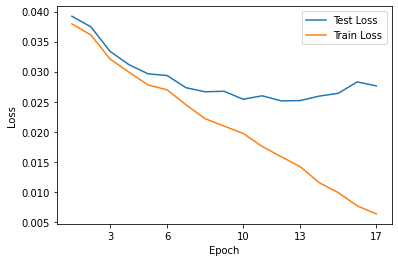

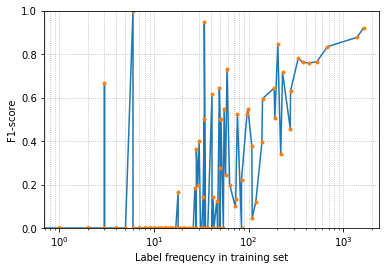

In [15]:
# set all values above threshold to 1, else 0
th = 0.5
y_pred = np.copy(y_pred_temp)
y_pred[y_pred > th] = 1
y_pred[y_pred <= th] = 0

# number of labels in test set
#labels_in_test = np.count_nonzero(np.sum(y_true, axis=0))
label_counts_test = np.sum(multilab_bin.transform(test_dataset['labels']), axis=0)
labels_in_test = np.count_nonzero(label_counts_test)

# number of labels in train set
label_counts_train = np.sum(multilab_bin.transform(train_dataset['labels']), axis=0)
labels_in_train = np.count_nonzero(label_counts_train)

# compute size of intersection between labels in train and test
label_counts_test[label_counts_test > 0] = 1
labels_bin_test = label_counts_test

label_counts_train[label_counts_train > 0] = 1
labels_bin_train = label_counts_train

labels_bin_sum = labels_bin_test + labels_bin_train
labels_intersect = np.count_nonzero(labels_bin_sum[labels_bin_sum == 2])

print(f'SEED: {SEED}')
print(path_to_bert)
print(f'Number of labels in training set: {labels_in_train}/{y_true.shape[1]} ({labels_in_train/y_true.shape[1]*100:.2f} %)')
print(f'Number of labels in test set: {labels_in_test}/{y_true.shape[1]} ({labels_in_test/y_true.shape[1]*100:.2f} %)')
print(f'Number of labels present in both sets: {labels_intersect}/{y_true.shape[1]} ({labels_intersect/y_true.shape[1]*100:.2f} %)')
print()
print(f"Micro-average F1-score: {f1_score(y_true, y_pred, average='micro')}")
print(f"Weighted-average F1-score: {f1_score(y_true, y_pred, average='weighted', zero_division=1)}")
print(f"Macro-average F1-score: {f1_score(y_true, y_pred, average='macro', zero_division=1)}")
#print(f"Sample-average Jaccard score: {jaccard_score(y_true, y_pred, average='samples', zero_division=1)}")
print(f"Accuracy (exact match): {accuracy_score(y_true, y_pred)}")
print(f"Hamming Loss: {hamming_loss(y_true, y_pred)}")

x = [x for x in range(1,len(train_losses)+1)]
xticks = [x*len(train_losses)//5 for x in range(1,6)]
plt.plot(x, test_losses)
plt.plot(x, train_losses)
plt.legend(['Test Loss', 'Train Loss'])
plt.xticks(xticks,xticks)
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.gca().set_ylim([0,0.1])
plt.show()

# plot f1-score in relation to label frequency in training set
f1_per_label = f1_score(y_true, y_pred, average=None, zero_division=0)
label_counts_train = np.sum(multilab_bin.transform(train_dataset['labels']), axis=0)
label_counts_test = np.sum(multilab_bin.transform(test_dataset['labels']), axis=0)

# only include labels that are present in the test set
zipped = [(f1_per_label[i], label_counts_test[i], label_counts_train[i]) for i in range(len(label_counts_test)) if label_counts_test[i] > 0]
zipped = sorted(zipped, key=lambda tup: tup[2])

f1_per_label = [zipped[i][0] for i in range(len(zipped))]
label_counts_train = [zipped[i][2] for i in range(len(zipped))]

# make a regression over the data points
#s = UnivariateSpline(label_counts_train, f1_per_label, k=3, s=5)
#xs = np.linspace(1,label_counts_train[-1])
#ys = s(xs)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(label_counts_train, f1_per_label)
plt.plot(label_counts_train, f1_per_label, '.')
#plt.plot(xs,ys)
ax.set_xscale('log')
ax.set_ylim((0,1))
plt.xlabel('Label frequency in training set')
plt.ylabel('F1-score')
plt.grid(True, which='both', linestyle=':')
plt.show()

In [16]:
model.eval()

# get a list of tuples containing the samples sorted by loss
sorted_samples = []

for i in range(len(test_dataset)):
    text = str(test_dataset['text'][i])
    text = ' '.join(text.split())

    inputs = tok.encode_plus(
        text,
        None,
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        padding='max_length',
        return_token_type_ids=True
    )
    ids = torch.tensor(inputs['input_ids'], dtype=torch.long).view(1,-1).to(device)
    mask = torch.tensor(inputs['attention_mask'], dtype=torch.long).view(1,-1).to(device)
    token_type_ids = torch.tensor(inputs['token_type_ids'], dtype=torch.long).view(1,-1).to(device)
    
    # get the prediction
    y_pred_row = model(ids, mask, token_type_ids).detach().cpu()

    # get the true labels
    y_true_row = torch.tensor(multilab_bin.transform([test_dataset['labels'][i]]), dtype=torch.float)

    # get the loss
    loss = criterion(y_pred_row, y_true_row)

    # convert predictions according to threshold
    y_pred_row[y_pred_row > th] = 1
    y_pred_row[y_pred_row <= th] = 0

    sorted_samples.append((y_pred_row, y_true_row, text, loss))

# sort samples with regard to loss
sorted_samples = sorted(sorted_samples, key=lambda tup: tup[-1])

In [ ]:
# print the m percent best/worst predictions based on loss
m = 50
best_worst = 'best'

nbr_elements = (len(test_dataset) * m) // 100

top_m = []
if best_worst == 'best':
  top_m = sorted_samples[:nbr_elements]
elif best_worst == 'worst':
  top_m = sorted_samples[len(sorted_samples)-nbr_elements:]
else:
  print('Please choose either "best" or "worst"')

for i in range(len(top_m)):
  tup = top_m[i]
  pred = multilab_bin.inverse_transform(tup[0])
  labels = multilab_bin.inverse_transform(tup[1])
  text = tup[2]
  loss = tup[3]

  print(f'Loss: {loss}')
  print(f'{text}')
  print(f'Prediction: {pred}')
  print(f'Labels: {labels}')
  print('- - - - - - - - - - - - - - - - - - - - - - - - -')